In [1]:
import pickle
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from math import sqrt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
games = pd.read_pickle('/Users/sec/galvanize/capstone1/game_data/all_games.pkl')

In [3]:
games.GameType.value_counts()

season2018     1101
season2017     1082
season2016     1078
season2015     1070
season2014     1062
tourney2014      49
tourney2016      47
tourney2015      43
tourney2017      40
tourney2018      23
Name: GameType, dtype: int64

In [4]:
def games_up_to_2018_season_filter(df):
    '''Filter for games up to 2018 season'''
    notourney2018 = (df['GameType'] != 'tourney2018')
    noseason2018 = (df['GameType'] != 'season2018')
    games_up_to_2018_season = df[notourney2018 & noseason2018]
    return games_up_to_2018_season

In [5]:
def season2018_filter(df):
    '''Filter for games up to 2018 season'''
    season2018cond = (df['GameType'] == 'season2018')
    season2018 = df[season2018cond]
    return season2018

In [6]:
games_up_to_2018_season = games_up_to_2018_season_filter(games)
games_up_to_2018_season.GameType.value_counts()

season2017     1082
season2016     1078
season2015     1070
season2014     1062
tourney2014      49
tourney2016      47
tourney2015      43
tourney2017      40
Name: GameType, dtype: int64

In [7]:
season2018 = season2018_filter(games)
season2018.GameType.value_counts()

season2018    1101
Name: GameType, dtype: int64

In [8]:
'''Shuffle DataFrames'''
games_up_to_2018_season = games_up_to_2018_season.sample(frac=1).reset_index(drop=True)
season2018 = season2018.sample(frac=1).reset_index(drop=True)

In [9]:
Xy_train = games_up_to_2018_season[['W', 'Wp', 'ppg', 'pApg', 'FGp', '3Pp', 'FTp', 'ORBpg', 'RBpg', 
            'ASTpg', 'STLpg', 'BLKpg', 'TOpg', 'PFpg', 'sos', 'OPWp', 'OPppg', 
            'OPpApg', 'OPFGp', 'OP3Pp', 'OPFTp', 'OPORBpg', 'OPRBpg', 
            'OPASTpg', 'OPSTLpg', 'OPBLKpg', 'OPTOpg', 'OPPFpg', 'OPsos']]

Xy_test = season2018[['W', 'Wp', 'ppg', 'pApg', 'FGp', '3Pp', 'FTp', 'ORBpg', 'RBpg', 
            'ASTpg', 'STLpg', 'BLKpg', 'TOpg', 'PFpg', 'sos', 'OPWp', 'OPppg', 
            'OPpApg', 'OPFGp', 'OP3Pp', 'OPFTp', 'OPORBpg', 'OPRBpg', 
            'OPASTpg', 'OPSTLpg', 'OPBLKpg', 'OPTOpg', 'OPPFpg', 'OPsos']]

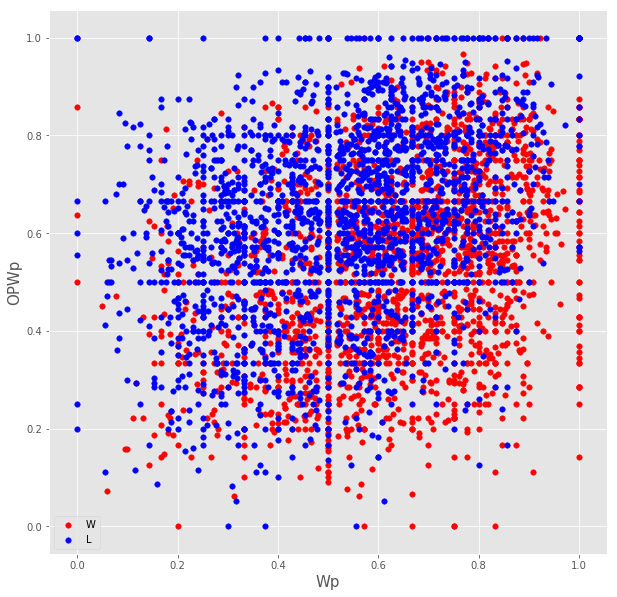

In [10]:
targetnames = ['L', 'W']
'''scatter plot for each feature colored by target'''
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
for W, color in zip(Xy_train.W.unique(), ['r', 'b']):
    sub_df = Xy_train.query('W == @W')
    ax.scatter(x=sub_df.Wp.values, y=sub_df.OPWp.values, color=color, label=targetnames[W], s=30)
ax.legend(loc='best')
ax.set_xlabel('Wp', size=15)
ax.set_ylabel('OPWp', size=15)
plt.show()

In [11]:
Xy_test['W'].value_counts() 
# pretty even on wins and losses

0    562
1    539
Name: W, dtype: int64

In [12]:
# Set up features and targets
X_train = Xy_train.iloc[:, 1:].as_matrix()
y_train = Xy_train.iloc[:, 0].as_matrix()

In [13]:
# Set up features and targets
X_test = Xy_test.iloc[:, 1:].as_matrix()
y_test = Xy_test.iloc[:, 0].as_matrix()

In [14]:
'''Standardize Data'''
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [15]:
'''Fit model on training data'''
lg = LogisticRegression()  # penalty='l2' as default which is Ridge
lg.fit(X_train, y_train)
lg_predict = lg.predict(X_test)
lg_predict_proba = lg.predict_proba(X_test)

In [16]:
lg_predict

array([1, 1, 0, ..., 0, 0, 0])

In [17]:
lg_predict_proba

array([[ 0.29694693,  0.70305307],
       [ 0.24333703,  0.75666297],
       [ 0.6459725 ,  0.3540275 ],
       ..., 
       [ 0.83651529,  0.16348471],
       [ 0.73619737,  0.26380263],
       [ 0.61618788,  0.38381212]])

In [18]:
y_score = lg_predict_proba[:, [0]]
y_score

array([[ 0.29694693],
       [ 0.24333703],
       [ 0.6459725 ],
       ..., 
       [ 0.83651529],
       [ 0.73619737],
       [ 0.61618788]])

In [19]:
coefficients = list(lg.coef_.ravel())
coefficients = [float(i) for i in coefficients]
features = Xy_test.columns
features = list(features[1:])

In [20]:
coefficient_df = pd.DataFrame(np.column_stack([features, coefficients]), 
                               columns=['Features', 'Coefficients'])

coefficient_df.set_index('Features')

,Coefficients
Features,
Wp,0.6246986648919218
ppg,-0.09410584253310554
pApg,-0.06810375071375131
FGp,0.10262079397000323
3Pp,0.010380770666390782
FTp,0.06169463859976474
ORBpg,0.07988971680159095
RBpg,0.011244903215775112
ASTpg,0.09870209027224625


In [21]:
lg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [22]:
lg_accuracy = metrics.accuracy_score(y_test, lg_predict)
lg_precision = metrics.precision_score(y_test, lg_predict)
lg_recall = metrics.recall_score(y_test, lg_predict)
lg_f1 = metrics.f1_score(y_test, lg_predict)
print('Accuracy: {:.2f} (% predicted correctly)'.format(lg_accuracy))
print('Precision: {:.2f} (predicted positives % correct)'.format(lg_precision))
print('Recall: {:.2f} (% of positives predicted correctly)'.format(lg_recall))
print('f1 Score: {:.2f} (weighted average of Precision and Recall)'.format(lg_f1))

Accuracy: 0.67 (% predicted correctly)
Precision: 0.66 (predicted positives % correct)
Recall: 0.66 (% of positives predicted correctly)
f1 Score: 0.66 (weighted average of Precision and Recall)


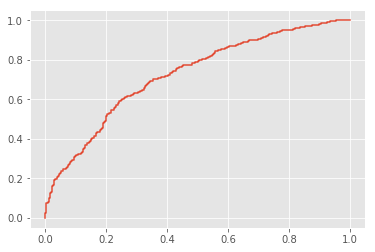

In [23]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.roc_auc_score(y_test, y_score)
plt.plot(tpr, fpr, label= 'AUC= {:.2f}'.format(roc_auc));

In [24]:
metrics.roc_auc_score(y_test, y_score)

0.27616384632144669

In [25]:
np.isnan(y_train)[np.isnan(y_train) == False].size

4471

In [26]:
'''Fit model on training data'''
lasso = LogisticRegression(penalty='l1')
lasso.fit(X_train, y_train)
lasso_predict = lg.predict(X_test)
lasso_predict_proba = lg.predict_proba(X_test)

In [27]:
lasso_accuracy = metrics.accuracy_score(y_test, lasso_predict)
lasso_precision = metrics.precision_score(y_test, lasso_predict)
lasso_recall = metrics.recall_score(y_test, lasso_predict)
lasso_f1 = metrics.f1_score(y_test, lasso_predict)
print('Accuracy: {:.2f} (% predicted correctly)'.format(lasso_accuracy))
print('Precision: {:.2f} (predicted positives % correct)'.format(lasso_precision))
print('Recall: {:.2f} (% of positives predicted correctly)'.format(lasso_recall))
print('f1 Score: {:.2f} (weighted average of Precision and Recall)'.format(lasso_f1))

Accuracy: 0.67 (% predicted correctly)
Precision: 0.66 (predicted positives % correct)
Recall: 0.66 (% of positives predicted correctly)
f1 Score: 0.66 (weighted average of Precision and Recall)


In [28]:
lasso_coefficients = list(lasso.coef_.ravel())
lasso_coefficients = [float(i) for i in lasso_coefficients]
features = Xy_test.columns
features = list(features[1:])

In [29]:
lasso_coefficient_df = pd.DataFrame(np.column_stack([features, lasso_coefficients]), 
                               columns=['Features', 'Coefficients'])

lasso_coefficient_df.set_index('Features')

,Coefficients
Features,
Wp,0.6220382253152582
ppg,-0.07292551644298512
pApg,-0.07577751025230695
FGp,0.09273580369005426
3Pp,0.007152106186472388
FTp,0.05760846260403703
ORBpg,0.07717820691303623
RBpg,0.003151144727460011
ASTpg,0.09570624618493304


## Cross Validation

In [30]:
logcv = LogisticRegression()
lassocv = LogisticRegression(penalty='l1')
log_cv_acc = cross_validate(logcv, X_train, y_train, scoring='accuracy', cv=5, return_train_score=False)
lasso_cv_acc = cross_validate(lassocv, X_train, y_train, scoring='accuracy', cv=5, return_train_score=False)
print('Logistic Regression (Ridge) Accuracy: {:.2f}'.format(log_cv_acc['test_score'].mean()))
print('Logistic Regression (Lasso) Accuracy: {:.2f}'.format(lasso_cv_acc['test_score'].mean()))

Logistic Regression (Ridge) Accuracy: 0.68
Logistic Regression (Lasso) Accuracy: 0.68


Cross Validation improves score by .01 or 1%

## Optimize C

In [31]:
Cs = list(np.linspace(0.1, 3, 100))
accs = []
for c in Cs:
    lgc = LogisticRegression(C=c)
    lgc.fit(X_train, y_train)
    lgc_acc = metrics.accuracy_score(y_test, lg_predict)
    accs.append(lgc_acc) 

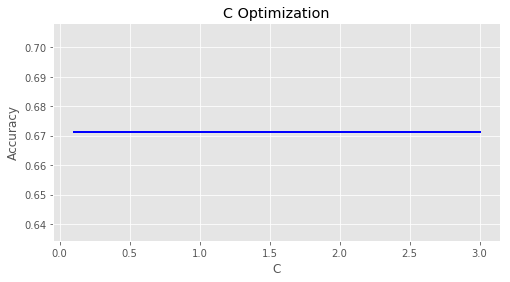

In [32]:
## initialize the axes
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

## format axes
ax.set_ylabel('Accuracy')
ax.set_xlabel('C')
ax.set_title('C Optimization')

line, = ax.plot(Cs, accs, color='blue', lw=2)

In [33]:
'''sklearn.model_selection.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, 
n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’)

class sklearn.model_selection.GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, 
n_jobs=1, iid=True, refit=True, cv=None, verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise’, 
return_train_score=’warn’)
'''
grid_search_results = GridSearchCV(lg, param_grid={'C':Cs}, scoring='accuracy', cv=5)
           
grid_search_results.fit(X_train, y_train)

grid_search_results.best_params_

{'C': 0.10000000000000001}